In [102]:
from astroNN.datasets import galaxy10sdss
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import pandas as pd
import seaborn as sns
import numpy as np
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torchvision.transforms as transform




In [103]:
images, labels=galaxy10sdss.load_data()

images=images.astype(np.float32)
Gal_train, Gal_test, lab_train, lab_test=train_test_split(images, labels, test_size=0.3, shuffle=True, random_state=5)
Gal_train=Gal_train/255.0
Gal_test=Gal_test/255.0

C:\Users\Alexb\.astroNN\datasets\Galaxy10.h5 was found!


In [104]:
Gal_train.shape, Gal_test.shape, lab_train.shape, lab_test.shape

((15249, 69, 69, 3), (6536, 69, 69, 3), (15249,), (6536,))

In [105]:

features=[feature for feature in galaxy10sdss.Galaxy10Class.values()]
    
for feature in features:
    print(feature)

Disk, Face-on, No Spiral
Smooth, Completely round
Smooth, in-between round
Smooth, Cigar shaped
Disk, Edge-on, Rounded Bulge
Disk, Edge-on, Boxy Bulge
Disk, Edge-on, No Bulge
Disk, Face-on, Tight Spiral
Disk, Face-on, Medium Spiral
Disk, Face-on, Loose Spiral


In [106]:
Ntransform=transform.Compose([transform.ToTensor()])

In [107]:
class Gal10Dataset(Dataset):
    def __init__(self, gal_data, labels, transform=None):
        self.gal_data=gal_data
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.gal_data)
    def __getitem__(self,idx):
        sample=self.gal_data[idx]
        label=self.labels[idx]
        if self.transform:
            sample=self.transform(sample)
        return sample, label

In [108]:
train_set=Gal10Dataset(Gal_train, lab_train, transform=Ntransform)
test_set=Gal10Dataset(Gal_test,lab_test, transform=Ntransform)

imgs=torch.stack([img for img, _ in train_set], dim=0)
mean=imgs.view(1, -1).mean(dim=1)
std=imgs.view(1, -1).std(dim=1)
print(mean, std)

resize_norm=transform.Compose([transform.ToTensor(), transform.Resize((32, 32)), transform.Normalize(mean=mean, std=std)])
normal_noResize=transform.Compose([transform.ToTensor(), transform.Normalize(mean=mean, std=std)])
train_set=Gal10Dataset(Gal_train, lab_train, transform=resize_norm)
test_set=Gal10Dataset(Gal_test, lab_test, transform=resize_norm)

train_loader=DataLoader(train_set, batch_size=32, shuffle=True)
test_loader=DataLoader(test_set, batch_size=32, shuffle=True)

tensor([0.0910]) tensor([0.1267])


In [109]:
len(train_loader), len(test_loader)

(477, 205)

In [110]:
print(train_loader)
print(len(train_loader.dataset))
print(len(train_loader))
print(train_loader.batch_size)
for x, y in train_loader:
    print(x.shape, x.dtype, y.shape)
    break

15249
477
32
torch.Size([32, 3, 32, 32]) torch.float32 torch.Size([32])


In [111]:
for images, labels in train_loader:
    print(images.shape, images.dtype)
    print(labels.shape, labels.dtype)
    break

torch.Size([32, 3, 32, 32]) torch.float32
torch.Size([32]) torch.uint8


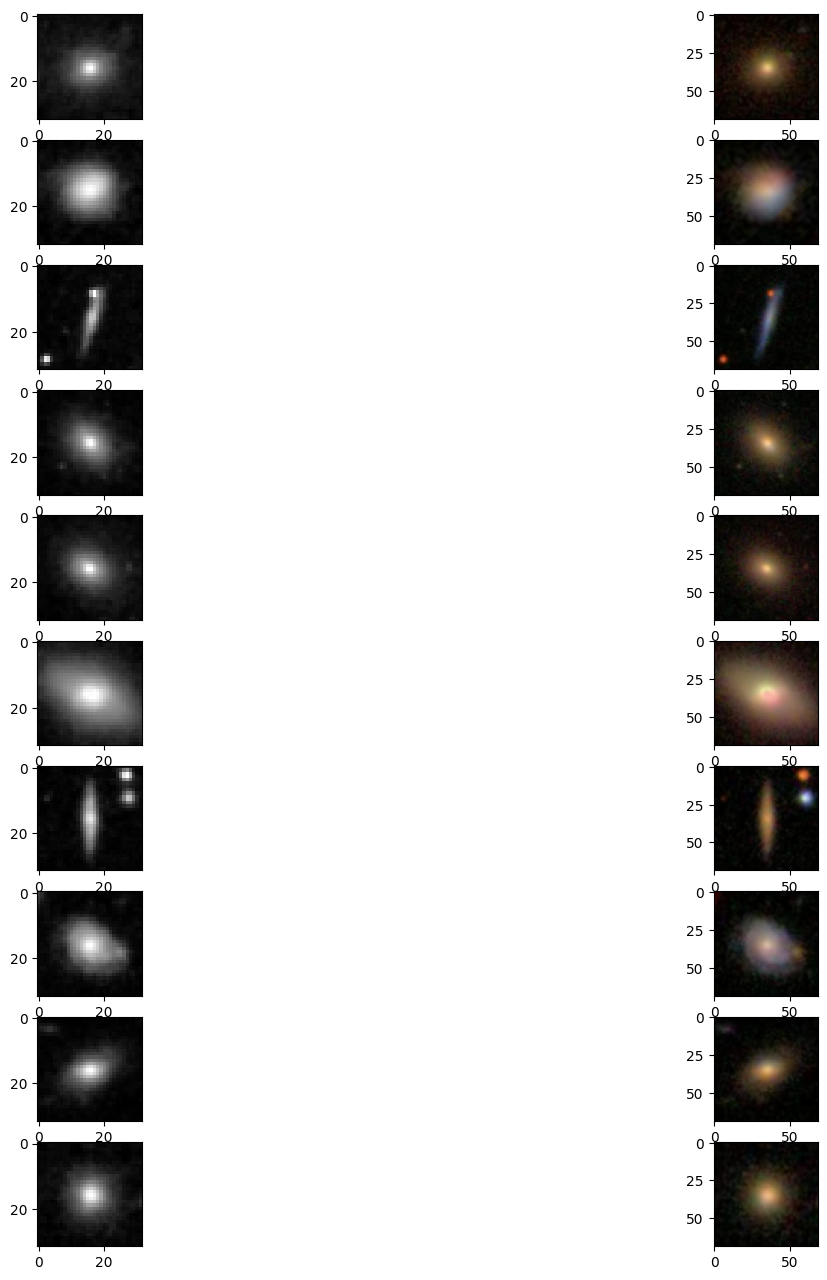

In [112]:

fig, axs=plt.subplots(10, 2, figsize=(16,16))
for i in range(10):
    axs[i, 0].imshow(train_loader.dataset[i][0][0], cmap='gray')
    axs[i, 1].imshow(Gal_train[i], cmap='gray')

In [120]:
#The convolutional NN
import torch.nn as nn
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.num_class=num_classes
        self.feature=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=self.num_class)
        )
        
    
    def forward(self, x):
        return self.classifier(self.feature(x))

In [121]:
device=(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [123]:
from torchinfo import summary
model=LeNet5(10)
summary(model=model, input_size=(1, 3, 32, 32), col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 3, 32, 32]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 3, 32, 32]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 6, 28, 28]       456                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

In [124]:
num_features=len(features)
learning_rate=0.001


model=LeNet5(num_classes=num_features).to(device=device)
loss_fn=nn.CrossEntropyLoss()

optim=torch.optim.Adam(model.parameters(),lr=learning_rate)

total_steps=len(train_loader)

In [125]:
def train(train_loader, model, optimizer, loss):
    correct=0
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target=data.to(device), target.to(device)
        
        output=model(data)
        loss=loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred=output.argmax(dim=1, keepdim=True)
        correct+=pred.eq(target.view_as(pred)).sum().item()
        
        if batch%100==0:
            print(f'Step: {batch*len(data)}/{len(train_loader.dataset)} Loss: {loss:.3f}')
    
    return 100*correct/len(train_loader.dataset)

In [126]:
def test(test_loader, model, loss_fn):
    model.eval()
    test_loss=0.0
    correct=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target=data.to(device), target.to(device)
            
            output=model(data)
            test_loss+=loss_fn(output, target).item()
            prediction=output.argmax(dim=1, keepdim=True)
            correct+=prediction.eq(target.view_as(prediction)).sum().item()
    test_loss/=len(test_loader)
    acc=100*correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.3f} Accuracy: {acc:.3f}")
    return acc

In [127]:
train_acc=[]
test_acc=[]
epochs=10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n======================================")
    train_acc.append(train(train_loader, model, optim, loss_fn))
    test_acc.append(test(test_loader, model, loss_fn))
    
print("Done!")
    

Epoch 1
Step: 0/15249 Loss: 2.254
Step: 3200/15249 Loss: 1.580
Step: 6400/15249 Loss: 1.221
Step: 9600/15249 Loss: 1.225
Step: 12800/15249 Loss: 1.239
Test loss: 1.023 Accuracy: 61.796
Epoch 2
Step: 0/15249 Loss: 0.893
Step: 3200/15249 Loss: 0.671
Step: 6400/15249 Loss: 0.863
Step: 9600/15249 Loss: 0.749
Step: 12800/15249 Loss: 0.703
Test loss: 0.883 Accuracy: 67.059
Epoch 3
Step: 0/15249 Loss: 0.748
Step: 3200/15249 Loss: 0.986
Step: 6400/15249 Loss: 0.617
Step: 9600/15249 Loss: 0.942
Step: 12800/15249 Loss: 1.069
Test loss: 0.792 Accuracy: 70.731
Epoch 4
Step: 0/15249 Loss: 1.101
Step: 3200/15249 Loss: 0.861
Step: 6400/15249 Loss: 0.723
Step: 9600/15249 Loss: 0.738
Step: 12800/15249 Loss: 0.821
Test loss: 0.770 Accuracy: 71.603
Epoch 5
Step: 0/15249 Loss: 0.777
Step: 3200/15249 Loss: 0.674
Step: 6400/15249 Loss: 0.585
Step: 9600/15249 Loss: 0.799
Step: 12800/15249 Loss: 0.891
Test loss: 0.772 Accuracy: 71.359
Epoch 6
Step: 0/15249 Loss: 1.231
Step: 3200/15249 Loss: 0.818
Step: 6400/1

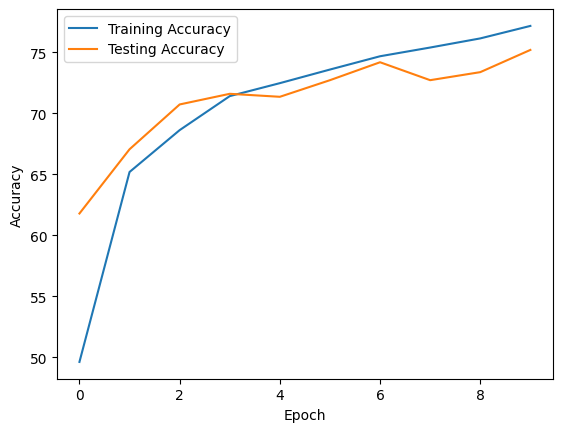

In [128]:
epoch=range(0,epochs)
plt.plot(epoch, train_acc, label="Training Accuracy")
plt.plot(epoch, test_acc, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [129]:
print(train_acc)
print(test_acc)

[49.636041707652964, 65.19771788313987, 68.62745098039215, 71.41451898485147, 72.47688373008066, 73.59171093186438, 74.68030690537084, 75.39510787592629, 76.14269788182831, 77.16571578464162]
[61.796205630354955, 67.0593635250918, 70.7313341493268, 71.60342717258261, 71.35862913096695, 72.7203182374541, 74.18910648714811, 72.7203182374541, 73.3782129742962, 75.19889840881272]


In [130]:
target_true=[]
target_pred=[]

for data, target in test_loader:
    data, target=data.to(device), target.to(device)
    
    output=model(data)
    _, predicted=torch.max(output, dim=1)
    
    target_true.extend(target.cpu().numpy())
    target_pred.extend(predicted.cpu().numpy())

In [131]:
report = classification_report(target_true, target_pred)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1008
           1       0.84      0.96      0.90      2110
           2       0.85      0.84      0.85      1910
           3       0.42      0.27      0.33       113
           4       0.82      0.79      0.80       470
           5       0.00      0.00      0.00         7
           6       0.62      0.89      0.73       173
           7       0.44      0.40      0.42       332
           8       0.58      0.19      0.29       243
           9       0.56      0.44      0.50       170

    accuracy                           0.75      6536
   macro avg       0.56      0.52      0.53      6536
weighted avg       0.74      0.75      0.74      6536



c:\Users\Alexb\Documents\Coding Python\galaxy_classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Alexb\Documents\Coding Python\galaxy_classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\Alexb\Documents\Coding Python\galaxy_classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Text(50.722222222222214, 0.5, 'Actual class')

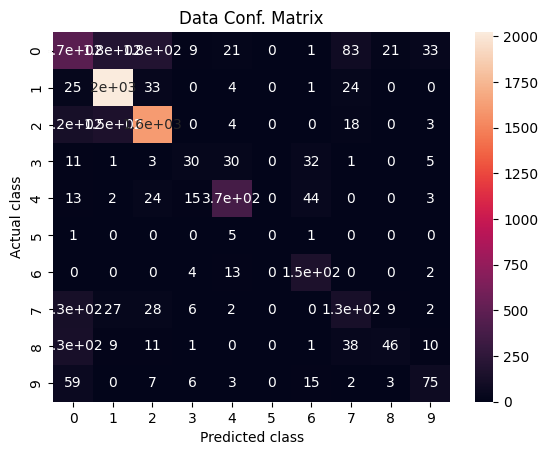

In [132]:
mat=confusion_matrix(target_true, target_pred)
sns.heatmap(mat, annot=True)
plt.title("Data Conf. Matrix")
plt.xlabel('Predicted class')
plt.ylabel('Actual class')